# Part 2: Trip Duration Prediction Model

This notebook builds a linear regression model to predict Citi Bike trip duration based on weather conditions and time features.

### Import Required Libraries

Import the necessary Python libraries for data manipulation, machine learning, and visualization:
- `pandas` and `numpy` for data handling
- `sklearn` for model building and evaluation
- `matplotlib` and `seaborn` for visualizations

In [2]:
# import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## Load Merged Data & Prepare Target

Load the merged trips and weather data from the datacleaning step, then create duration features and time-based variables.

In [3]:
# 1. Load CSV from datacleaning
print("="*60)
print("LOADING MERGED DATA")
print("="*60)

df = pd.read_csv("modeling_dataset.csv", parse_dates=["starttime"])

print(f"\n✓ Merged dataset loaded successfully!")
print(f"  Initial shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

# 2. Create duration and basic filters
print("\n" + "="*60)
print("CREATING DURATION & APPLYING FILTERS")
print("="*60)

df["trip_duration_min"] = df["tripduration"] / 60
print(f"\nBefore filtering: {len(df):,} rows")

df = df[(df["trip_duration_min"] >= 1) & (df["trip_duration_min"] <= 120)]
print(f"After filtering (1-120 min): {len(df):,} rows")

# 3. Create log target
df["log_duration"] = np.log(df["trip_duration_min"])
print(f"\n✓ Created log_duration target variable")

# 4. Time features
print("\n" + "="*60)
print("CREATING TIME FEATURES")
print("="*60)

df["weekday"] = df["starttime"].dt.weekday   # 0=Mon
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# Create hour if not already present
if "hour" not in df.columns:
    df["hour"] = df["starttime"].dt.hour

print(f"\n✓ Time features created:")
print(f"  - weekday (0=Mon, 6=Sun)")
print(f"  - is_weekend (0=weekday, 1=weekend)")
print(f"  - hour (0-23)")

print(f"\nFinal dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df[["starttime", "trip_duration_min", "log_duration", "hour", "weekday", "is_weekend"]].head(3))
print("="*60)

LOADING MERGED DATA

✓ Merged dataset loaded successfully!
  Initial shape: (18799954, 38)
  Rows: 18,799,954
  Columns: 38

CREATING DURATION & APPLYING FILTERS

Before filtering: 18,799,954 rows
After filtering (1-120 min): 18,799,954 rows

✓ Created log_duration target variable

CREATING TIME FEATURES

✓ Time features created:
  - weekday (0=Mon, 6=Sun)
  - is_weekend (0=weekday, 1=weekend)
  - hour (0-23)

Final dataset shape: (18799954, 38)

First few rows:
                starttime  trip_duration_min  log_duration  hour  weekday  \
0 2018-09-01 00:00:05.269          27.250000      3.305054     0        5   
1 2018-09-01 00:00:11.281           2.200000      0.788457     0        5   
2 2018-09-01 00:00:20.649          55.616667      4.018483     0        5   

   is_weekend  
0           1  
1           1  
2           1  


## Exploratory Data Analysis (EDA)
- Distribution of trip duration
- PCA on weather features (temperature, precipitation, wind)
- Correlation analysis
- Visualizations

### Distribution of Trip duration

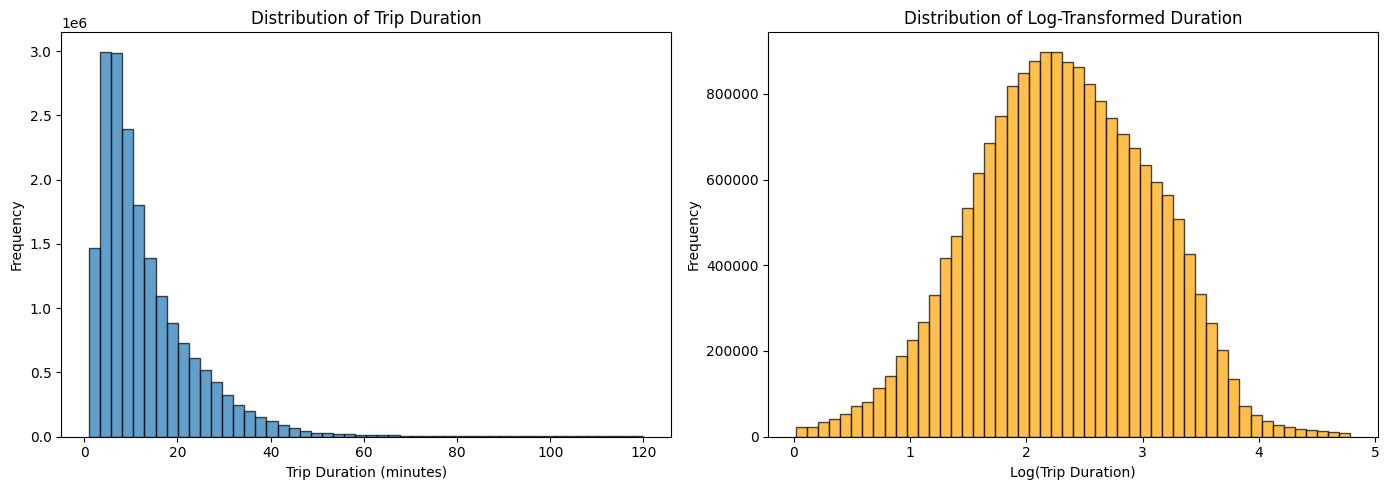

In [4]:
# Trip duration distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw duration
axes[0].hist(df["trip_duration_min"], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Trip Duration (minutes)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Trip Duration")

# Log-transformed duration
axes[1].hist(df["log_duration"], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel("Log(Trip Duration)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Log-Transformed Duration")

plt.tight_layout()
plt.show()

### PCA on weather features

PCA ON WEATHER FEATURES

Weather features selected:
  - temperature_2m_(°c)
  - precip_mm
  - wind_kmh

Samples after dropping NaN: 18,799,954

✓ Features standardized (mean=0, std=1)

✓ PCA completed with 2 components

Explained variance ratio:
  PC1: 0.3989 (39.89%)
  PC2: 0.3480 (34.80%)
  Total: 0.7468 (74.68%)

PCA components (loadings):
                          PC1       PC2
temperature_2m_(°c) -0.631107  0.483197
precip_mm            0.247636  0.866854
wind_kmh             0.735105  0.122819


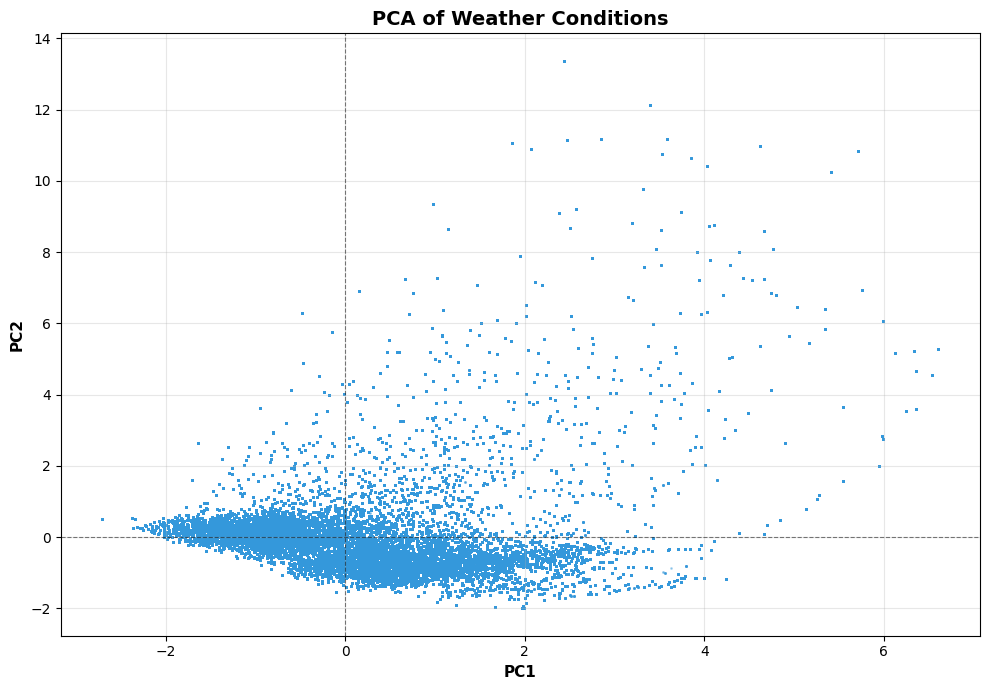

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("=" * 60)
print("PCA ON WEATHER FEATURES")
print("=" * 60)

# Select weather features and drop missing values
weather_feats = df[["temperature_2m_(°c)", "precip_mm", "wind_kmh"]].dropna()

print(f"\nWeather features selected:")
print(f"  - temperature_2m_(°c)")
print(f"  - precip_mm")
print(f"  - wind_kmh")
print(f"\nSamples after dropping NaN: {len(weather_feats):,}")

# Standardize features
scaler = StandardScaler()
scaled = scaler.fit_transform(weather_feats)
print(f"\n✓ Features standardized (mean=0, std=1)")

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled)

# Add principal components back to dataframe
df.loc[weather_feats.index, "pc1"] = pcs[:, 0]
df.loc[weather_feats.index, "pc2"] = pcs[:, 1]

print(f"\n✓ PCA completed with 2 components")
print(f"\nExplained variance ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

print(f"\nPCA components (loadings):")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['temperature_2m_(°c)', 'precip_mm', 'wind_kmh']
)
print(components_df)

# Plot PCA scatter
plt.figure(figsize=(10, 7))
plt.scatter(df["pc1"], df["pc2"], alpha=0.2, s=1, c='#3498db')
plt.xlabel("PC1", fontsize=11, fontweight='bold')
plt.ylabel("PC2", fontsize=11, fontweight='bold')
plt.title("PCA of Weather Conditions", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

### Summary Tables by Weather Conditions

In [6]:
# Summary by temperature bin (if temp_bin column exists, otherwise create it)
if "temp_bin" not in df.columns:
    df["temp_bin"] = pd.cut(df["temperature_2m_(°c)"], 
                            bins=[-20, 0, 10, 20, 30, 50], 
                            labels=["<0°C", "0–10°C", "10–20°C", "20–30°C", ">30°C"])

print("=" * 60)
print("TRIP DURATION BY TEMPERATURE BIN")
print("=" * 60)
temp_summary = df.groupby("temp_bin")["trip_duration_min"].agg(["count", "mean", "median"])
print(temp_summary)

# Summary by rain
print("\n" + "=" * 60)
print("TRIP DURATION BY RAIN FLAG")
print("=" * 60)
rain_summary = df.groupby("rain_flag")["trip_duration_min"].agg(["count", "mean", "median"])
print(rain_summary)

TRIP DURATION BY TEMPERATURE BIN
            count       mean     median
temp_bin                               
0–10°C    5111718  12.054928   9.033333
10–20°C   5256055  13.705909  10.300000
20–30°C   6905244  14.392969  10.900000
<0°C       882865  11.089231   8.433333
>30°C      644072  14.181058  10.850000

TRIP DURATION BY RAIN FLAG
              count       mean     median
rain_flag                                
0          16081967  13.504532  10.116667
1           2717987  12.800593   9.583333


### Weather Impact Visualization 

Visualize how weather conditions affect trip duration based on the actual observed data.

/var/folders/qp/5zn1806d2q183t3j1x_pt5x80000gn/T/ipykernel_2940/2579793665.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_means = df.groupby("wind_bin")["trip_duration_min"].mean()


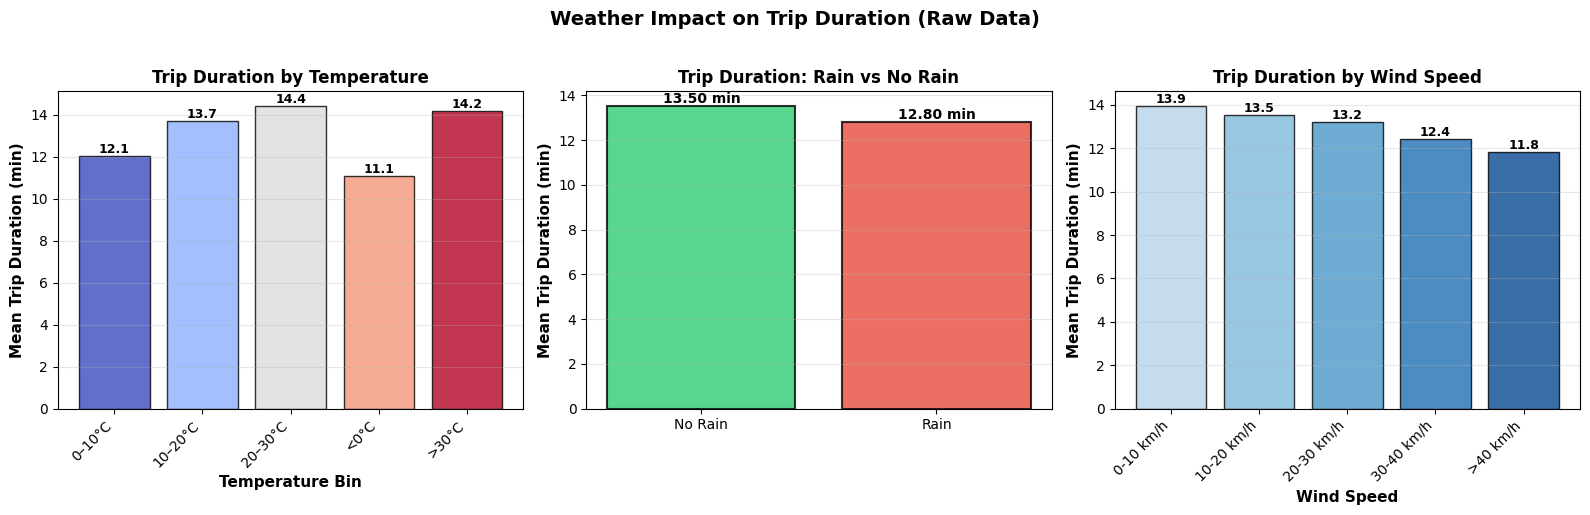


📊 Key Observations:
  • No Rain mean duration: 13.50 min
  • Rain mean duration: 12.80 min
  • Difference: 0.70 min (5.2% longer when dry)


In [15]:
# Visualization: Weather Impact on Trip Duration (Raw Data)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Trip Duration by Temperature Bin (Bar Chart)
ax1 = axes[0]
temp_means = df.groupby("temp_bin")["trip_duration_min"].mean().sort_index()
colors_temp = plt.cm.coolwarm(np.linspace(0, 1, len(temp_means)))
bars1 = ax1.bar(range(len(temp_means)), temp_means.values, color=colors_temp, alpha=0.8, edgecolor='black')
ax1.set_xticks(range(len(temp_means)))
ax1.set_xticklabels(temp_means.index, rotation=45, ha='right')
ax1.set_xlabel('Temperature Bin', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mean Trip Duration (min)', fontsize=11, fontweight='bold')
ax1.set_title('Trip Duration by Temperature', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Trip Duration: Rain vs No Rain (Bar Chart)
ax2 = axes[1]
rain_means = df.groupby("rain_flag")["trip_duration_min"].mean()
rain_labels = ['No Rain', 'Rain']
colors_rain = ['#2ecc71', '#e74c3c']
bars2 = ax2.bar(rain_labels, rain_means.values, color=colors_rain, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Mean Trip Duration (min)', fontsize=11, fontweight='bold')
ax2.set_title('Trip Duration: Rain vs No Rain', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f} min',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Trip Duration by Wind Speed (Binned)
ax3 = axes[2]
# Create wind speed bins
df["wind_bin"] = pd.cut(df["wind_kmh"], bins=[0, 10, 20, 30, 40, 100], 
                         labels=["0-10", "10-20", "20-30", "30-40", ">40"])
wind_means = df.groupby("wind_bin")["trip_duration_min"].mean()
colors_wind = plt.cm.Blues(np.linspace(0.3, 0.9, len(wind_means)))
bars3 = ax3.bar(range(len(wind_means)), wind_means.values, color=colors_wind, alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(wind_means)))
ax3.set_xticklabels([f"{l} km/h" for l in wind_means.index], rotation=45, ha='right')
ax3.set_xlabel('Wind Speed', fontsize=11, fontweight='bold')
ax3.set_ylabel('Mean Trip Duration (min)', fontsize=11, fontweight='bold')
ax3.set_title('Trip Duration by Wind Speed', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Weather Impact on Trip Duration (Raw Data)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"  • No Rain mean duration: {rain_means[0]:.2f} min")
print(f"  • Rain mean duration: {rain_means[1]:.2f} min")
print(f"  • Difference: {rain_means[0] - rain_means[1]:.2f} min ({((rain_means[0] - rain_means[1])/rain_means[0])*100:.1f}% longer when dry)")

### Correlation Analysis 

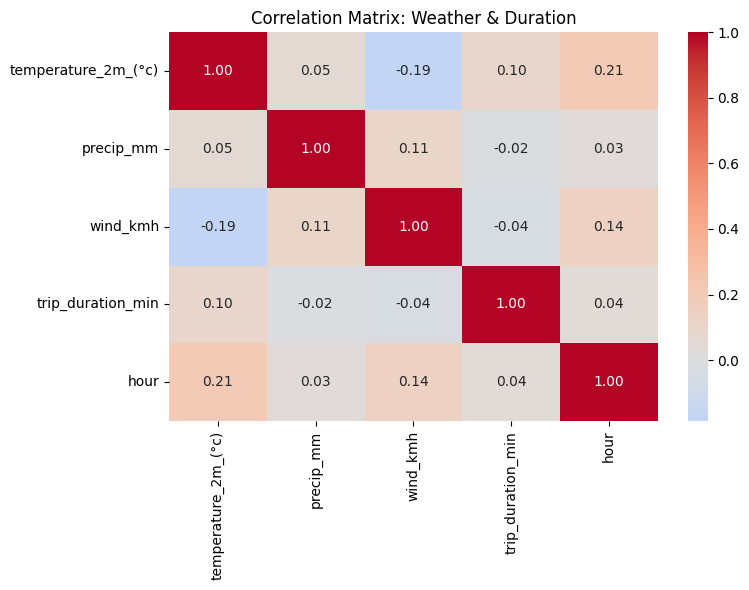

In [7]:
# Correlation heatmap for numeric features
numeric_cols = ["temperature_2m_(°c)", "precip_mm", "wind_kmh", "trip_duration_min", "hour"]
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix: Weather & Duration")
plt.tight_layout()
plt.show()

## Feature engineering

In [8]:


print("=" * 60)
print("BUILDING FEATURE MATRIX X AND TARGET y")
print("=" * 60)

# Define the features to use
features = [
    "temperature_2m_(°c)",
    "rain_flag",
    "wind_kmh",
    "hour",
    "weekday",
    "is_weekend",
]

print(f"\nSelected features:")
for i, feat in enumerate(features, 1):
    print(f"  {i}. {feat}")

# Create feature matrix
X = df[features].copy()

# One-hot encode categorical variables (hour and weekday)
# drop_first=True avoids multicollinearity (dummy variable trap)
X = pd.get_dummies(X, columns=["hour", "weekday"], drop_first=True)

# Define target variable (log-transformed duration)
y = df["log_duration"]

# Summary
print(f"\n" + "-" * 60)
print("FEATURE MATRIX SUMMARY")
print("-" * 60)
print(f"\nX shape: {X.shape}")
print(f"  Rows (samples): {X.shape[0]:,}")
print(f"  Columns (features): {X.shape[1]}")

print(f"\ny shape: {y.shape[0]:,}")
print(f"\nFeature columns:")
print(X.columns.tolist())

print(f"\n" + "=" * 60)

BUILDING FEATURE MATRIX X AND TARGET y

Selected features:
  1. temperature_2m_(°c)
  2. rain_flag
  3. wind_kmh
  4. hour
  5. weekday
  6. is_weekend

------------------------------------------------------------
FEATURE MATRIX SUMMARY
------------------------------------------------------------

X shape: (18799954, 33)
  Rows (samples): 18,799,954
  Columns (features): 33

y shape: 18,799,954

Feature columns:
['temperature_2m_(°c)', 'rain_flag', 'wind_kmh', 'is_weekend', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']



# Train / Test split 

In [9]:

from sklearn.model_selection import train_test_split

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42  # For reproducibility
)

# Print shapes to confirm
print(f"\nTraining set:")
print(f"  X_train: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"  y_train: {y_train.shape[0]:,} samples")

print(f"\nTest set:")
print(f"  X_test: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"  y_test: {y_test.shape[0]:,} samples")

print(f"\nSplit ratio:")
print(f"  Train: {len(X_train) / len(X) * 100:.1f}%")
print(f"  Test:  {len(X_test) / len(X) * 100:.1f}%")

print("=" * 60)

TRAIN/TEST SPLIT

Training set:
  X_train: 15,039,963 samples × 33 features
  y_train: 15,039,963 samples

Test set:
  X_test: 3,759,991 samples × 33 features
  y_test: 3,759,991 samples

Split ratio:
  Train: 80.0%
  Test:  20.0%


## Model 1: Linear regression

### Train the model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("=" * 60)
print("LINEAR REGRESSION MODEL")
print("=" * 60)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print(f"\n✓ Linear Regression model trained successfully!")
print(f"  Intercept: {lr_model.intercept_:.4f}")
print(f"  Number of coefficients: {len(lr_model.coef_)}")

LINEAR REGRESSION MODEL

✓ Linear Regression model trained successfully!
  Intercept: 2.0724
  Number of coefficients: 33


### Evaluate (R², RMSE)

In [11]:
# ============================================================
# MODEL EVALUATION
# ============================================================
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Predictions on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"\nLinear Regression Performance:")
print(f"  R² Score: {r2_lr:.4f}")
print(f"  RMSE: {rmse_lr:.4f}")

print(f"\nInterpretation:")
print(f"  • R² of {r2_lr:.4f} means the model explains {r2_lr*100:.2f}% of variance in log(duration)")
print(f"  • RMSE of {rmse_lr:.4f} is the average prediction error in log scale")
print("=" * 60)


MODEL EVALUATION

Linear Regression Performance:
  R² Score: 0.0234
  RMSE: 0.7555

Interpretation:
  • R² of 0.0234 means the model explains 2.34% of variance in log(duration)
  • RMSE of 0.7555 is the average prediction error in log scale


### Coefficient Analysis

In [12]:

print("\n" + "=" * 60)
print("COEFFICIENT ANALYSIS")
print("=" * 60)

# Create coefficient dataframe
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr_model.coef_
}).sort_values("coefficient", ascending=False)

print(f"\nTotal features: {len(coef_df)}")

# Top 10 positive coefficients (increase trip duration)
print("\n📈 Top 10 POSITIVE coefficients (increase trip duration):")
print(coef_df.head(10).to_string(index=False))

# Top 10 negative coefficients (decrease trip duration)
print("\n📉 Top 10 NEGATIVE coefficients (decrease trip duration):")
print(coef_df.tail(10).to_string(index=False))

# Weather-specific coefficients
print("\n" + "-" * 60)
print("WEATHER FEATURE COEFFICIENTS")
print("-" * 60)
weather_coefs = coef_df[coef_df["feature"].str.contains("temperature|rain_flag|wind", case=False)]
print(weather_coefs.to_string(index=False))

print("\nInterpretation:")
print("  • Positive coefficient → increases trip duration")
print("  • Negative coefficient → decreases trip duration")
print("=" * 60)


COEFFICIENT ANALYSIS

Total features: 33

📈 Top 10 POSITIVE coefficients (increase trip duration):
feature  coefficient
hour_14     0.185608
hour_15     0.183637
hour_17     0.179195
hour_16     0.173493
hour_13     0.160328
hour_11     0.160262
hour_12     0.151454
hour_18     0.145169
 hour_8     0.135313
hour_10     0.116776

📉 Top 10 NEGATIVE coefficients (decrease trip duration):
  feature  coefficient
weekday_3    -0.003417
weekday_2    -0.004022
weekday_1    -0.011498
   hour_1    -0.034674
rain_flag    -0.064089
   hour_2    -0.071511
   hour_6    -0.074063
   hour_3    -0.082452
   hour_5    -0.114455
   hour_4    -0.115742

------------------------------------------------------------
WEATHER FEATURE COEFFICIENTS
------------------------------------------------------------
            feature  coefficient
temperature_2m_(°c)     0.008250
           wind_kmh    -0.001732
          rain_flag    -0.064089

Interpretation:
  • Positive coefficient → increases trip duration
  • Ne

### Vizualizations

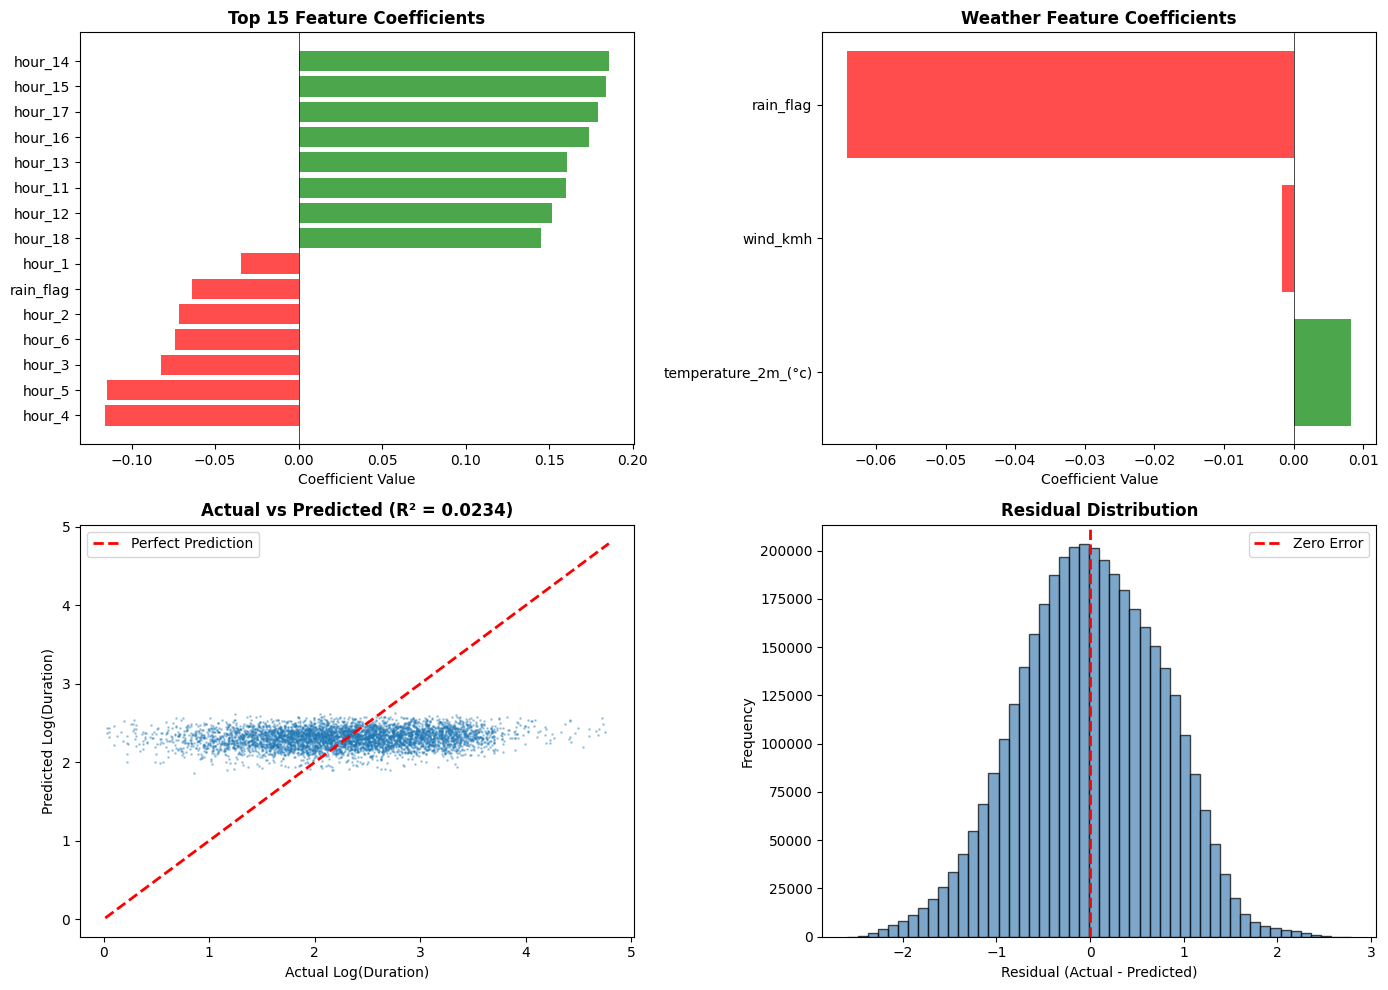


✓ Visualizations saved to 'linear_regression_results.png'


In [13]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Top 15 Feature Coefficients (Bar Chart)
ax1 = axes[0, 0]
top_coefs = pd.concat([coef_df.head(8), coef_df.tail(7)])
colors = ['green' if c > 0 else 'red' for c in top_coefs['coefficient']]
ax1.barh(top_coefs['feature'], top_coefs['coefficient'], color=colors, alpha=0.7)
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Top 15 Feature Coefficients', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.invert_yaxis()

# 2. Weather Coefficients Only
ax2 = axes[0, 1]
weather_only = coef_df[coef_df["feature"].isin(["temperature_2m_(°c)", "rain_flag", "wind_kmh"])]
colors_weather = ['green' if c > 0 else 'red' for c in weather_only['coefficient']]
ax2.barh(weather_only['feature'], weather_only['coefficient'], color=colors_weather, alpha=0.7)
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Weather Feature Coefficients', fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# 3. Actual vs Predicted (scatter - sample for speed)
ax3 = axes[1, 0]
sample_idx = np.random.choice(len(y_test), size=min(5000, len(y_test)), replace=False)
ax3.scatter(y_test.iloc[sample_idx], y_pred_lr[sample_idx], alpha=0.3, s=1)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Log(Duration)')
ax3.set_ylabel('Predicted Log(Duration)')
ax3.set_title(f'Actual vs Predicted (R² = {r2_lr:.4f})', fontweight='bold')
ax3.legend()

# 4. Residual Distribution
ax4 = axes[1, 1]
residuals = y_test - y_pred_lr
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Residual (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution', fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('linear_regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved to 'linear_regression_results.png'")

## Model 2: Gradient boosting

### Train the model

In [ ]:
# ============================================================
# GRADIENT BOOSTING MODEL
# ============================================================
from sklearn.ensemble import GradientBoostingRegressor

print("=" * 60)
print("GRADIENT BOOSTING MODEL")
print("=" * 60)

# Initialize the model with hyperparameters
# Note: Training may take 15-25 minutes due to large dataset (~15M samples)
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages (trees)
    max_depth=5,           # Maximum depth of each tree
    learning_rate=0.1,     # Shrinks contribution of each tree
    subsample=0.8,         # Fraction of samples for fitting each tree
    random_state=42,
    verbose=1              # Show progress during training
)

print(f"\nHyperparameters:")
print(f"  n_estimators: {gb_model.n_estimators}")
print(f"  max_depth: {gb_model.max_depth}")
print(f"  learning_rate: {gb_model.learning_rate}")
print(f"  subsample: {gb_model.subsample}")

print(f"\n⏳ Training Gradient Boosting model...")
print(f"   This may take 15-25 minutes due to the large dataset...\n")

# Train the model
gb_model.fit(X_train, y_train)

print(f"\n✓ Gradient Boosting model trained successfully!")

### Evaluate (R², RMSE)

In [ ]:
# ============================================================
# MODEL EVALUATION
# ============================================================
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Predictions on test set
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"\nGradient Boosting Performance:")
print(f"  R² Score: {r2_gb:.4f}")
print(f"  RMSE: {rmse_gb:.4f}")

print(f"\nInterpretation:")
print(f"  • R² of {r2_gb:.4f} means the model explains {r2_gb*100:.2f}% of variance in log(duration)")
print(f"  • RMSE of {rmse_gb:.4f} is the average prediction error in log scale")
print("=" * 60)

### Feature Importance

In [ ]:

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

# Create feature importance dataframe
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": gb_model.feature_importances_
}).sort_values("importance", ascending=False)

print(f"\nTotal features: {len(importance_df)}")

# Top 15 most important features
print("\n🏆 Top 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Weather feature importance
print("\n" + "-" * 60)
print("WEATHER FEATURE IMPORTANCE")
print("-" * 60)
weather_importance = importance_df[importance_df["feature"].str.contains("temperature|rain_flag|wind", case=False)]
print(weather_importance.to_string(index=False))

# Calculate total importance by category
weather_total = importance_df[importance_df["feature"].str.contains("temperature|rain|wind", case=False)]["importance"].sum()
hour_total = importance_df[importance_df["feature"].str.contains("hour_", case=False)]["importance"].sum()
weekday_total = importance_df[importance_df["feature"].str.contains("weekday_|is_weekend", case=False)]["importance"].sum()

print(f"\nImportance by Category:")
print(f"  Weather features: {weather_total*100:.2f}%")
print(f"  Hour features: {hour_total*100:.2f}%")
print(f"  Weekday features: {weekday_total*100:.2f}%")
print("=" * 60)

### Vizualizations

In [ ]:
# ============================================================
# VISUALIZATIONS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Top 15 Feature Importances (Bar Chart)
ax1 = axes[0, 0]
top_15 = importance_df.head(15)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_15)))[::-1]
ax1.barh(top_15['feature'], top_15['importance'], color=colors)
ax1.set_xlabel('Importance')
ax1.set_title('Gradient Boosting - Top 15 Feature Importances', fontweight='bold')
ax1.invert_yaxis()

# 2. Weather vs Time Feature Importance (Pie Chart)
ax2 = axes[0, 1]
categories = ['Weather\n(temp, rain, wind)', 'Hour', 'Weekday/Weekend']
totals = [weather_total, hour_total, weekday_total]
colors_pie = ['#3498db', '#e74c3c', '#2ecc71']
ax2.pie(totals, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Feature Importance by Category', fontweight='bold')

# 3. Actual vs Predicted (scatter - sample for speed)
ax3 = axes[1, 0]
sample_idx = np.random.choice(len(y_test), size=min(5000, len(y_test)), replace=False)
ax3.scatter(y_test.iloc[sample_idx], y_pred_gb[sample_idx], alpha=0.3, s=1, c='orange')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Log(Duration)')
ax3.set_ylabel('Predicted Log(Duration)')
ax3.set_title(f'Actual vs Predicted (R² = {r2_gb:.4f})', fontweight='bold')
ax3.legend()

# 4. Residual Distribution
ax4 = axes[1, 1]
residuals_gb = y_test - y_pred_gb
ax4.hist(residuals_gb, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Residual (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution', fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('gradient_boosting_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved to 'gradient_boosting_results.png'")

## Model comparison and conclussion

In [ ]:


print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "Metric": ["R² Score", "RMSE", "Variance Explained"],
    "Linear Regression": [f"{r2_lr:.4f}", f"{rmse_lr:.4f}", f"{r2_lr*100:.2f}%"],
    "Gradient Boosting": [f"{r2_gb:.4f}", f"{rmse_gb:.4f}", f"{r2_gb*100:.2f}%"]
})

print("\n" + comparison_df.to_string(index=False))

# Calculate improvement
r2_improvement = ((r2_gb - r2_lr) / r2_lr) * 100 if r2_lr > 0 else float('inf')
rmse_improvement = ((rmse_lr - rmse_gb) / rmse_lr) * 100

print("\n" + "-" * 60)
print("IMPROVEMENT ANALYSIS")
print("-" * 60)
print(f"\nGradient Boosting vs Linear Regression:")
if r2_gb > r2_lr:
    print(f"  ✓ R² improvement: +{r2_improvement:.1f}%")
else:
    print(f"  ✗ R² decrease: {r2_improvement:.1f}%")
    
if rmse_gb < rmse_lr:
    print(f"  ✓ RMSE improvement: {rmse_improvement:.1f}% lower error")
else:
    print(f"  ✗ RMSE increase: {abs(rmse_improvement):.1f}% higher error")

print("=" * 60)

### Vizualizations

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. R² Score Comparison (Bar Chart)
ax1 = axes[0, 0]
models = ['Linear Regression', 'Gradient Boosting']
r2_scores = [r2_lr, r2_gb]
colors = ['steelblue', 'orange']
bars = ax1.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison', fontweight='bold')
ax1.set_ylim(0, max(r2_scores) * 1.3)
# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. RMSE Comparison (Bar Chart)
ax2 = axes[0, 1]
rmse_scores = [rmse_lr, rmse_gb]
bars = ax2.bar(models, rmse_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE Comparison (lower is better)', fontweight='bold')
ax2.set_ylim(0, max(rmse_scores) * 1.2)
for bar, score in zip(bars, rmse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Actual vs Predicted - Both Models
ax3 = axes[1, 0]
sample_idx = np.random.choice(len(y_test), size=min(3000, len(y_test)), replace=False)
ax3.scatter(y_test.iloc[sample_idx], y_pred_lr[sample_idx], alpha=0.3, s=5, 
            label=f'Linear Regression (R²={r2_lr:.3f})', c='steelblue')
ax3.scatter(y_test.iloc[sample_idx], y_pred_gb[sample_idx], alpha=0.3, s=5, 
            label=f'Gradient Boosting (R²={r2_gb:.3f})', c='orange')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Log(Duration)')
ax3.set_ylabel('Predicted Log(Duration)')
ax3.set_title('Actual vs Predicted - Model Comparison', fontweight='bold')
ax3.legend(loc='upper left')

# 4. Residual Distribution Comparison
ax4 = axes[1, 1]
residuals_lr = y_test - y_pred_lr
residuals_gb = y_test - y_pred_gb
ax4.hist(residuals_lr, bins=50, alpha=0.5, label='Linear Regression', color='steelblue', density=True)
ax4.hist(residuals_gb, bins=50, alpha=0.5, label='Gradient Boosting', color='orange', density=True)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residual (Actual - Predicted)')
ax4.set_ylabel('Density')
ax4.set_title('Residual Distribution Comparison', fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualizations saved to 'model_comparison.png'")